<a href="https://colab.research.google.com/github/M0n1ka-05/Topic-Modelling-on-news-article/blob/main/Monika_Shinde_Team_3_Capestone_Project_4_Topic_Modeling_on_News_Articles_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Extraction/identification of major topics & themes discussed in news articles. </u></b>

## <b> Problem Description </b>

### In this project your task is to identify major themes/topics across a collection of BBC news articles. You can use clustering algorithms such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) etc.

## <b> Data Description </b>

### The dataset contains a set of news articles for each major segment consisting of business, entertainment, politics, sports and technology. You need to create an aggregate dataset of all the news articles and perform topic modeling on this dataset. Verify whether these topics correspond to the different tags available.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
import ast

In [3]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

In [4]:
business_path= glob.glob("/content/drive/MyDrive/AlmaBetter/Cohort Aravali/Module 4/Week 4/bbc/business/*.txt")
entertainment_path = glob.glob("/content/drive/MyDrive/AlmaBetter/Cohort Aravali/Module 4/Week 4/bbc/entertainment/*.txt")
politics_path = glob.glob("/content/drive/MyDrive/AlmaBetter/Cohort Aravali/Module 4/Week 4/bbc/politics/*.txt")
sports_path = glob.glob("/content/drive/MyDrive/AlmaBetter/Cohort Aravali/Module 4/Week 4/bbc/sport/*.txt")
tech_path = glob.glob("/content/drive/MyDrive/AlmaBetter/Cohort Aravali/Module 4/Week 4/bbc/tech/*.txt")


In [5]:
len(tech_path)

401

In [6]:
#file_list = [business_path[:400],entertainment_path[:400],politics_path[:400],sports_path[:400],tech_path[:400]]
file_list = [business_path,entertainment_path,politics_path,sports_path,tech_path]


In [21]:
corpus = []

for file_path in file_list:
  for path in file_path:
    with open(path,encoding='utf-8', errors='ignore') as file_input:
      corpus.append(file_input.read())
print (corpus)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
len(corpus)

2225

In [9]:
type(corpus)

list

In [10]:
new_df = pd.DataFrame (corpus,columns=['news'])

In [11]:
new_df.head(5)

,news
0,Yukos unit buyer faces loan claim\n\nThe owner...
1,Ad sales boost Time Warner profit\n\nQuarterly...
2,Dollar gains on Greenspan speech\n\nThe dollar...
3,US trade gap hits record in 2004\n\nThe gap be...
4,High fuel prices hit BA's profits\n\nBritish A...


In [22]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize
import seaborn as sns


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
def rmv_punctuation(text):
    return ''.join(s for s in text if s not in punctuation)

In [14]:
new_df['news'] = new_df['news'].apply(rmv_punctuation)


In [15]:
# extracting the stopwords from nltk library
sw = stopwords.words('english')
# displaying the stopwords
np.array(sw)

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

In [16]:
def rmv_stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [17]:
new_df['news'] = new_df['news'].apply(rmv_stopwords)
new_df.head(10)

,news
0,yukos unit buyer faces loan claim owners embat...
1,ad sales boost time warner profit quarterly pr...
2,dollar gains greenspan speech dollar hit highe...
3,us trade gap hits record 2004 gap us exports i...
4,high fuel prices hit bas profits british airwa...
5,india widens access telecoms india raised limi...
6,yukos loses us bankruptcy battle judge dismiss...
7,ask jeeves tips online ad revival ask jeeves b...
8,indonesians face fuel price rise indonesias go...
9,telegraph newspapers axe 90 jobs daily sunday ...


In [18]:
new_df.shape

(2225, 1)

In [19]:
new_df.head(5)

,news
0,yukos unit buyer faces loan claim owners embat...
1,ad sales boost time warner profit quarterly pr...
2,dollar gains greenspan speech dollar hit highe...
3,us trade gap hits record 2004 gap us exports i...
4,high fuel prices hit bas profits british airwa...


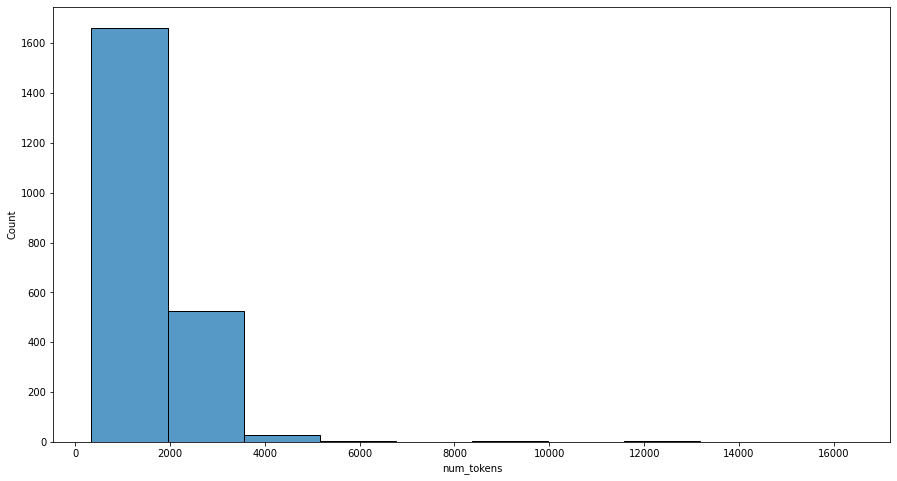

In [23]:
# Sum the number of tokens in each Doc
new_df['num_tokens'] = [len(token) for token in new_df.news]
# Visualize histogram of tokens per tweet
plt.figure(figsize=(15,8))
g = sns.histplot(new_df.num_tokens, bins = 10)

In [25]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

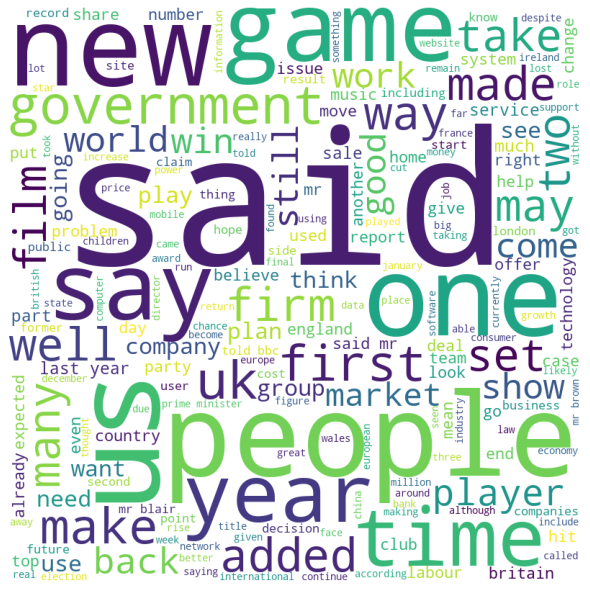

In [26]:
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in new_df.news: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [27]:
news_data = new_df['news']

In [28]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_news = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_news, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_news.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

In [29]:
news_data.values

array(['yukos unit buyer faces loan claim owners embattled russian oil giant yukos ask buyer former production unit pay back 900m £479m loan stateowned rosneft bought yugansk unit 93bn sale forced russia part settle 275bn tax claim yukos yukos owner menatep group says ask rosneft repay loan yugansk secured assets rosneft already faces similar 540m repayment demand foreign banks legal experts said rosnefts purchase yugansk would include obligations pledged assets rosneft pay real money creditors avoid seizure yugansk assets said moscowbased us lawyer jamie firestone connected case menatep groups managing director tim osborne told reuters news agency default fight rule law exists international arbitration clauses credit rosneft officials unavailable comment company said intends take action menatep recover tax claims debts owed yugansk yukos filed bankruptcy protection us court attempt prevent forced sale main production arm sale went ahead december yugansk sold littleknown shell company 

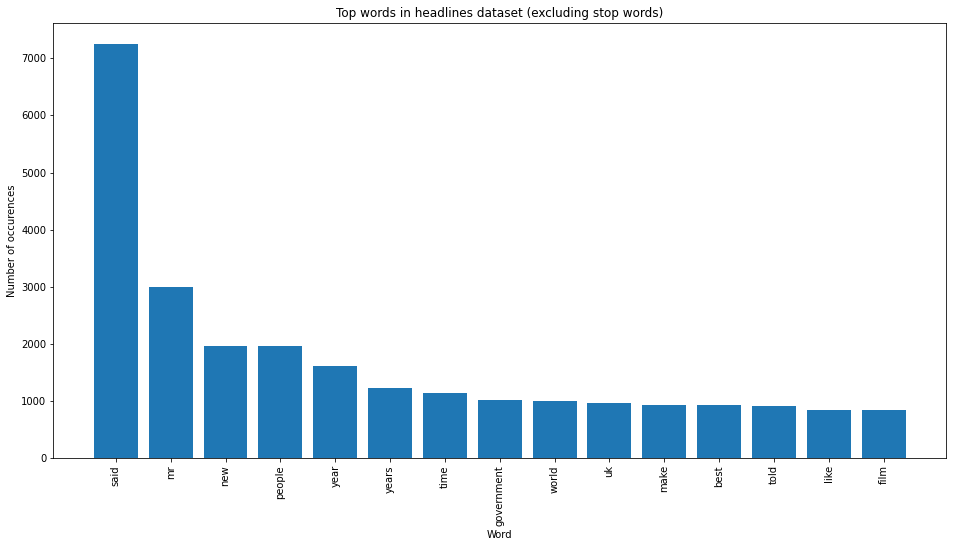

In [30]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=news_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top words in headlines dataset (excluding stop words)')
ax.set_xlabel('Word')
ax.set_ylabel('Number of occurences')
plt.show()